<h1><center>3-point perspective</center></h1>

<center><a href = "mailto: joseph.d.romano@gmail.com">joseph.d.romano@gmail.com</a></center>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#mpl.rcParams['figure.dpi'] = 200
#mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

# Various functions

In [3]:
def standardCube():
    '''
    generate array of vertices for a standard cube 
    (edge length=1, corner vertex at origin)
    '''
    
    P = np.zeros((8,3))

    P[0,:] = np.array([0, 0, 0])
    P[1,:] = np.array([1, 0, 0])
    P[2,:] = np.array([1, 0, 1])
    P[3,:] = np.array([0, 0, 1])
    P[4,:] = np.array([0, 1, 0])
    P[5,:] = np.array([1, 1, 0])
    P[6,:] = np.array([1, 1, 1])
    P[7,:] = np.array([0, 1, 1])
    
    return P

In [4]:
def scale(P, scalefactors):
    '''
    scale points by 3-d scalefactors
    '''
    
    scalex = scalefactors[0]
    scaley = scalefactors[1]
    scalez = scalefactors[2]
    
    N = P.shape[0]
    Q = np.empty_like(P)
    
    for ii in range(0,N):
        Q[ii,0] = scalex*P[ii,0]
        Q[ii,1] = scaley*P[ii,1]
        Q[ii,2] = scalez*P[ii,2]
        
    return Q

In [5]:
def translate(P, shift):
    '''
    translate points by 3-d shift vector
    '''
    
    N = P.shape[0]
    Q = np.empty_like(P)
    
    for ii in range(0,N):
        Q[ii,:] = P[ii,:] + shift
        
    return Q

In [6]:
def Rx(a):
    '''
    calculate passive rotation matrix around x-axis
    '''
    
    R = np.array([[1,          0,         0],
                  [0,  np.cos(a), np.sin(a)],
                  [0, -np.sin(a), np.cos(a)]])
    
    return R

In [7]:
def Ry(a):
    '''
    calculate passive rotation matrix around y-axis
    '''
    
    R = np.array([[np.cos(a), 0, -np.sin(a)], 
                  [0,         1,          0],
                  [np.sin(a), 0,  np.cos(a)]])
    
    return R

In [8]:
def Rz(a):
    '''
    calculate passive rotation matrix around z-axis
    '''
    
    R = np.array([[ np.cos(a), np.sin(a), 0], 
                  [-np.sin(a), np.cos(a), 0],
                  [         0,         0, 1]])
    
    return R

In [9]:
def rotate(P, axis, angle, prevRot):
    '''
    actively rotate points P->Q about transformed axis thru angle (in radians)
    
    prevRot: previous rotation matrix (3x3)
    '''
    
    # passive rotation matrix about axis thru angle
    if axis == 'x':
        rot = Rx(angle)
        
    if axis == 'y':
        rot = Ry(angle)
        
    if axis == 'z':
        rot = Rz(angle)
        
    # convert to active rotation
    R = np.linalg.inv(rot)
    
    # conjugate R by previous active rotation to rotate around *transformed* axis
    Rprime = np.dot(prevRot, np.dot(R, np.linalg.inv(prevRot)) )
    
    # new combined rotation
    newRot = np.dot(Rprime, prevRot)
    
    # rotate points
    N = P.shape[0]
    Q = np.empty_like(P)
    
    for ii in range(0,N):
        Q[ii,:] = np.dot(newRot, P[ii,:])
        
    # rotate unit vectors
    a_vec = np.dot(newRot, np.array([1, 0, 0]))
    b_vec = np.dot(newRot, np.array([0, 1, 0]))
    c_vec = np.dot(newRot, np.array([0, 0, 1]))
    
    return Q, a_vec, b_vec, c_vec, newRot

In [10]:
def xyz2uv(P, d, h):
    '''
    perspective transformation from P=(x,y,z) to (u,v)
    
    d: distance to picture plane
    h: height of horizon line
    '''
    
    x = P[0]
    y = P[1]
    z = P[2]
    
    u = d*x/y
    v = d*(z-h)/y + h
    
    return u, v

In [11]:
def vanishingPoints(d, h, a, b, c):
    '''
    calculate location of VPs in PP
    
    d = distance from EP to PP
    h = distance from EP to GP
    a,b,c = 3-d unit vectors pointing along the cube's x,y,z axes
    '''
    
    # tolerance for zero value
    tol = 1.e-6

    # default values
    VPx = np.array([np.Inf, np.Inf])
    VPy = np.array([np.Inf, np.Inf])
    VPz = np.array([np.Inf, np.Inf])
    
    # calculate VPx
    if np.abs(a[1]) > tol:
        u = d*a[0]/a[1]
        v = h + d*a[2]/a[1]
        VPx = np.array([u, v])
        
    # calculate VPy
    if abs(b[1]) > tol:
        u = d*b[0]/b[1]
        v = h + d*b[2]/b[1]
        VPy = np.array([u, v])
        
    # calculate VPz
    if abs(c[1]) > tol:
        u = d*c[0]/c[1]
        v = h + d*c[2]/c[1]
        VPz = np.array([u, v])
        
    return VPx, VPy, VPz

# Interactive 3-point perspective code



input axis (x,y,z; w to quit): z
input angle (degrees): 30


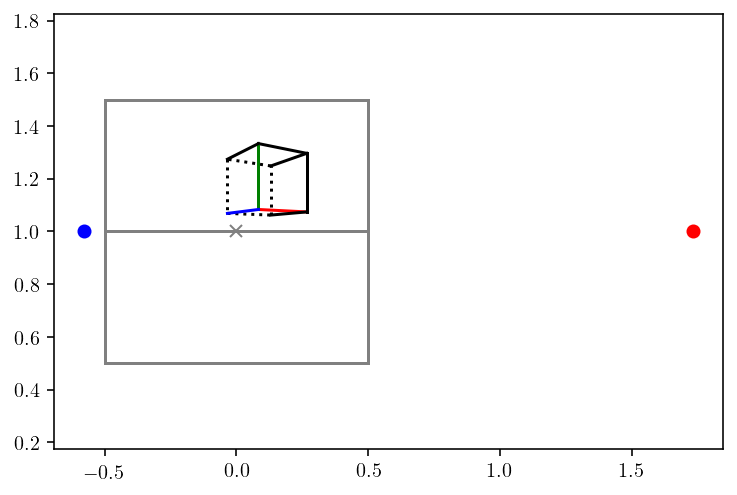



input axis (x,y,z; w to quit): x
input angle (degrees): 30


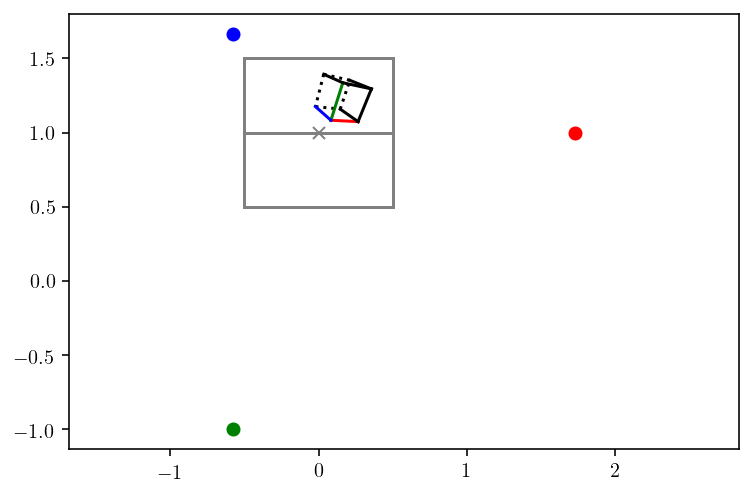



input axis (x,y,z; w to quit): y
input angle (degrees): -15


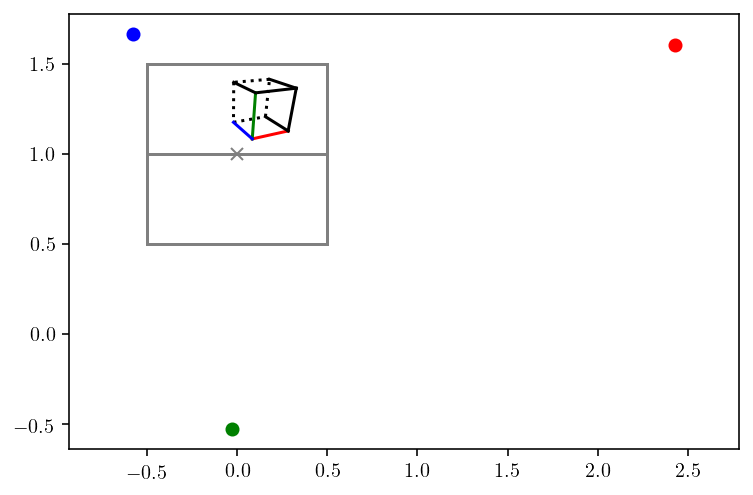



input axis (x,y,z; w to quit): z
input angle (degrees): 10


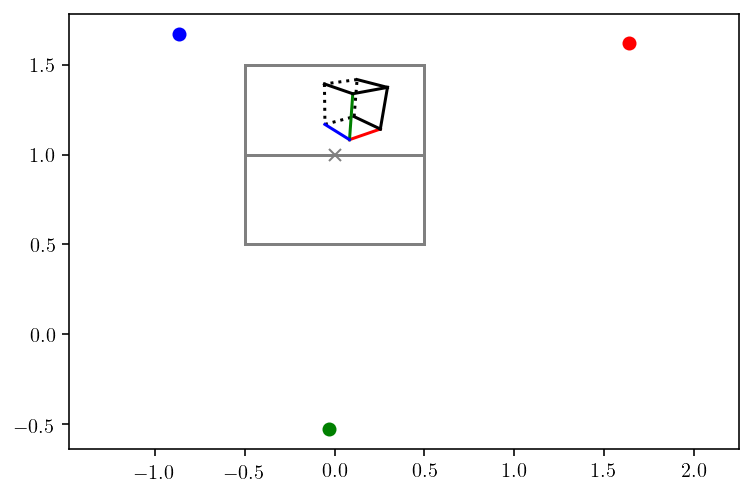



input axis (x,y,z; w to quit): y
input angle (degrees): -10


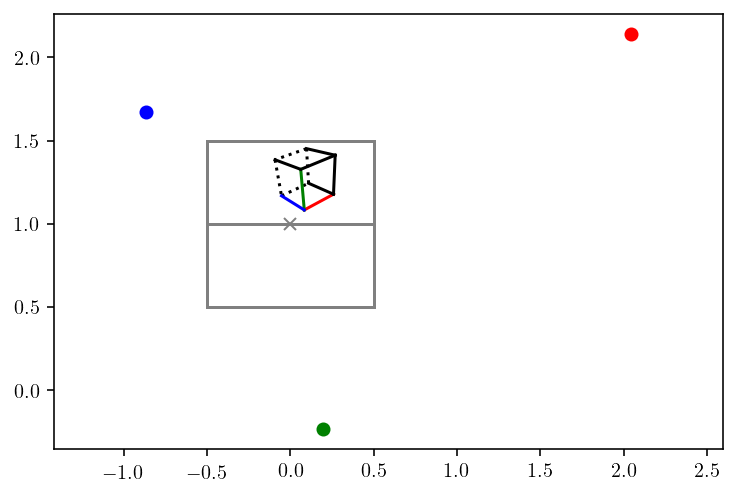



input axis (x,y,z; w to quit): w


In [12]:
# interactive 3-point perspective of a box

# number of vertices for box
N = 8

# distance of eye point to picture plane
d = 1

# height of horizon line above ground plane
h = 1

# approximately 30 degree angular field
ulim = 0.5*d
vlim = 0.5*d

# shift vector for eventual translation of a point in physical space beyond picture plane
#shift = np.array([0, d+5, h]) # vertex at CP on HL
shift = np.array([-0.5+1, d+5, h-0.5+1]) # right and above HL
   
# generate vertices for standard cube 
V0 = standardCube()
    
# scale cube ('box' = rectangular parallelpiped)
#scalefactors = np.array([2, 1, 1])
scalefactors = np.array([1.5, 1.5, 1.5])
V1 = scale(V0, scalefactors)
    
# initial rotation (identity)
prevRot = np.eye(3)
    
# loop for successive rotations
counter = 1
while 1!=0:
    
    # input axis, angle
    print('\n')
    axis  = input('input axis (x,y,z; w to quit): ')
    if axis=='w':
        break
        
    angle = input('input angle (degrees): ')
    
    # convert string input to float and degrees to radians
    angle = float(angle)
    angle = np.deg2rad(angle)
    
    # perform rotation
    V2, a_vec, b_vec, c_vec, newRot = rotate(V1, axis, angle, prevRot)

    # perform translation to a point in physical space beyond picture plane
    V3 = translate(V2, shift)
    
    # perform perspective transformation from physical space to picture plane
    u = np.zeros(N)
    v = np.zeros(N)
    
    for ii in range(0,N):
        u[ii], v[ii] = xyz2uv(V3[ii,:], d, h)
    
    # calculate vanishing points
    VPx, VPy, VPz = vanishingPoints(d, h, a_vec, b_vec, c_vec)
    
    # plot
    plt.figure()
    
    # horizon line
    plt.plot(np.array([-ulim, ulim]), np.array([h, h]), color='grey')
    
    # picture plane
    plt.plot(np.array([-ulim, ulim]), np.array([h+vlim, h+vlim]), color='grey')
    plt.plot(np.array([-ulim, ulim]), np.array([h-vlim, h-vlim]), color='grey')
    plt.plot(np.array([-ulim, -ulim]), np.array([h-vlim, h+vlim]), color='grey')
    plt.plot(np.array([ulim, ulim]), np.array([h-vlim, h+vlim]), color='grey')
    
    # vanishing points
    plt.plot(VPx[0], VPx[1], 'ro')
    plt.plot(VPy[0], VPy[1], 'bo')
    plt.plot(VPz[0], VPz[1], 'go')
    
    # center point
    plt.plot(0, h, color='grey', marker='x')
    
    # back
    plt.plot(np.array([u[4], u[5]]), np.array([v[4], v[5]]), color='k', linestyle=':')
    plt.plot(np.array([u[5], u[6]]), np.array([v[5], v[6]]), color='k', linestyle=':')
    plt.plot(np.array([u[6], u[7]]), np.array([v[6], v[7]]), color='k', linestyle=':')
    plt.plot(np.array([u[7], u[4]]), np.array([v[7], v[4]]), color='k', linestyle=':')
    
    # front
    plt.plot(np.array([u[0], u[1]]), np.array([v[0], v[1]]), color='r', linestyle='-')
    plt.plot(np.array([u[1], u[2]]), np.array([v[1], v[2]]), color='k', linestyle='-')
    plt.plot(np.array([u[2], u[3]]), np.array([v[2], v[3]]), color='k', linestyle='-')
    plt.plot(np.array([u[3], u[0]]), np.array([v[3], v[0]]), color='g', linestyle='-')
    
    # right side
    plt.plot(np.array([u[2], u[6]]), np.array([v[2], v[6]]), color='k', linestyle='-')
    plt.plot(np.array([u[1], u[5]]), np.array([v[1], v[5]]), color='k', linestyle='-')
    
    # left side
    plt.plot(np.array([u[0], u[4]]), np.array([v[0], v[4]]), color='b', linestyle='-')
    plt.plot(np.array([u[3], u[7]]), np.array([v[3], v[7]]), color='k', linestyle='-')
    
    # equal aspect ratio
    plt.axis('equal')
    
    # savefig
    figtitle = 'threepoint_' + str(counter)
    plt.savefig(figtitle, bbox_inches='tight', dpi=400)
    
    # display figure
    plt.show()
    
    # prepare for next rotation
    prevRot = newRot
    counter = counter + 1
    
